/home/pawel/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pawel/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pawel/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pawel/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

-------------


GPU:True


-------------
Num GPUs: 1

tracking <tf.Variable 'ws_alpha:0' shape=() dtype=float32> alpha
tracking <tf.Variable 'ws_alpha_1:0' shape=() dtype=float32> alpha
tracking <tf.Variable 'ws_alpha_2:0' shape=() dtype=float32> alpha
tracking <tf.Variable 'ws_alpha_3:0' shape=() dtype=float32> alpha
tracking <tf.Variable 'ws_alpha_4:0' shape=() dtype=float32> alpha
tracking <tf.Variable 'ws_alpha_5:0' shape=() dtype=float32> alpha
tracking <tf.Variable 'ws_alpha_6:0' shape=() dtype=float32> alpha
tracking <tf.Variable 'ws_alpha_7:0' shape=() dtype=float32> alpha
tracking <tf.Variable 'ws_alpha_8:0' shape=() dtype=float32> alpha
tracking <tf.Variable 'ws_alpha_9:0' shape=() dtype=float32> alpha
tracking <tf.Variable 'ws_alpha_10:0' shape=() dtype=float32> alpha
tracking <tf.Variable 'ws_alpha_11:0' shape=() dtype=float32> alpha
Found 1360 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Scaled Data (None, 4, 4, 3)

Instructions for updating:
Use t

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>7/5440, d1=3.798, d2=-1.974 g=7.003

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>5440/5440, d1=-37.708, d2=116.502 g=-112.1533
>Saved: plot_004x004-tuned.png and model_004x004-tuned.h5


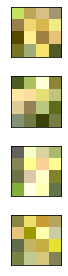

Found 1360 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Scaled Data (None, 8, 8, 3)


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>5/5440, d1=-17.727, d2=79.721 g=-103.061

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>5440/5440, d1=4560.286, d2=-6534.572 g=7681.89789
>Saved: plot_008x008-faded.png and model_008x008-faded.h5


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>6/5440, d1=5402.289, d2=-7616.973 g=7934.559

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>5440/5440, d1=20739.215, d2=-22862.836 g=24698.490
>Saved: plot_008x008-tuned.png and model_008x008-tuned.h5


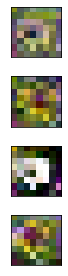

Found 1360 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Scaled Data (None, 16, 16, 3)


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>6/10880, d1=25672.367, d2=-22302.664 g=24380.023

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>10880/10880, d1=-2487.418, d2=2274.694 g=-2014.7721
>Saved: plot_016x016-faded.png and model_016x016-faded.h5


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>6/10880, d1=-2513.515, d2=2236.615 g=-1873.985

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>10880/10880, d1=694.403, d2=-470.767 g=235.6501649
>Saved: plot_016x016-tuned.png and model_016x016-tuned.h5


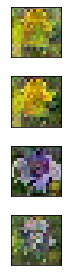

Found 1360 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Scaled Data (None, 32, 32, 3)


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>4/10880, d1=301.201, d2=416.641 g=58.771

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>10880/10880, d1=-195.211, d2=283.295 g=-172.93079
>Saved: plot_032x032-faded.png and model_032x032-faded.h5


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>4/10880, d1=-274.769, d2=298.796 g=-267.293

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>10880/10880, d1=-158.115, d2=186.702 g=-183.35071
>Saved: plot_032x032-tuned.png and model_032x032-tuned.h5


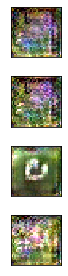

Found 1360 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Scaled Data (None, 64, 64, 3)


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>3/43520, d1=-77.367, d2=57.290 g=-203.005

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>43520/43520, d1=32.428, d2=-93.630 g=-75.4180326
>Saved: plot_064x064-faded.png and model_064x064-faded.h5


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>3/43520, d1=-88.200, d2=93.722 g=-78.980

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>43520/43520, d1=552.962, d2=-2450.315 g=714.46999376
>Saved: plot_064x064-tuned.png and model_064x064-tuned.h5


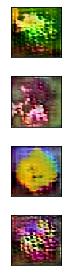

Found 1360 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Scaled Data (None, 128, 128, 3)


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1/43520, d1=4503.209, d2=-1536.217 g=-125.908

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>43520/43520, d1=2620.873, d2=-4629.435 g=6863.7571595
>Saved: plot_128x128-faded.png and model_128x128-faded.h5


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1/43520, d1=10070.973, d2=-5374.537 g=3629.799

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>43520/43520, d1=209714.000, d2=-201464.031 g=64697.9386
>Saved: plot_128x128-tuned.png and model_128x128-tuned.h5


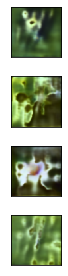

Found 1360 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Scaled Data (None, 256, 256, 3)


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1/43520, d1=54685.625, d2=-117491.648 g=32495.250

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>43520/43520, d1=-70772.828, d2=38136.625 g=61825.1377325600
>Saved: plot_256x256-faded.png and model_256x256-faded.h5


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1/43520, d1=-48075.812, d2=39746.414 g=-22139.098

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>673/43520, d1=-57987.688, d2=71382.586 g=-83332.3285

In [ ]:
from progan import main
main(4, 1, dataset_name="flowers", n_epochs= [1, 1, 1, 1, 1, 1, 1], n_batch=[16, 16, 8, 8, 4, 4, 4], learning_rate=0.00025)  